In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from json import loads

In [2]:
def plot_states(colors):

    indexes_dict = labeled_data_test.groupby('state').indices
    
    for key in indexes_dict:
        new_list = []
        
        prev_ind = indexes_dict[key][0]
        new_list.append(prev_ind)

        for inds in indexes_dict[key][1:]:
            

            if inds - prev_ind > 1 : # plot backgroud color for new state
                new_list.append(prev_ind)

                plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

                new_list = []
                new_list.append(inds)

            if inds == indexes_dict[key][-1]: # plot backgroud color for las state

                new_list.append(inds)

                plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

            prev_ind = inds

def plot_accuracy_likelihood(prediction_window, rolling_window):

    print(f"Steps {prediction_window} - MA Window {rolling_window}")
    scaler = MinMaxScaler() 
    accuracy_scaled = scaler.fit_transform(labeled_data_test[f'accuracy - {prediction_window} step'].rolling(rolling_window).mean().values.reshape(-1, 1))
    log_likelihood_scaled = scaler.fit_transform(labeled_data_test[f'log_likelihood - {prediction_window} step'].values.reshape(-1, 1))

    plt.figure(figsize=(12, 8), dpi=80)
    plt.plot(accuracy_scaled, color='black', label='Accuracy')
    plt.plot(log_likelihood_scaled, color='b', label='Log Likelihood')
    
    colors = {'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'plum', 'mining': 'peachpuff', 'stream': 'silver'}
    print(colors)
    plot_states(colors)

    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [3]:
feature_names = 'cpu-all_mem'

model_names = ['rvp_random_48hr','rvp_pattern_48hr','rvp_random_48hr_2','rvp_pattern_48hr_2']

data_associations_dict = {'RPi4B8GB':{'freq':1800,'train_data':{},'test_data':{},'features':feature_names}, 'RPi4B4GB':{'freq':1500,'train_data':{},'test_data':{},'features':feature_names}, 'RPi4B2GB2':{'freq':1500,'train_data':{},'test_data':{},'features':feature_names}, 'RPi4B2GB1':{'freq':1200,'train_data':{},'test_data':{},'features':feature_names}} 

lookback = 300

In [4]:
"""Prepare data dict"""
for device in data_associations_dict:
    for model in model_names:
        data_associations_dict[device]['train_data'][model] = (pd.read_csv(f"data/{device}_{data_associations_dict[device]['freq']}MHz_res_usage_data_train_pred_{model}.csv"))
        labeled_data_test = pd.read_csv(f"data/{device}_{data_associations_dict[device]['freq']}MHz_res_usage_data_test_pred_{model}.csv")
        data_associations_dict[device]['test_data'][model] = (labeled_data_test[lookback:]) # remove lookback section

In [5]:
"""Training Classification Accuracy"""
train_accuracy_states = {}

for device in data_associations_dict:
    print(device)
    train_accuracy_states[device] = {}
    for model in data_associations_dict[device]['train_data']:
        print(model)
        train_accuracy_states[device][model] = []
        for name,group in data_associations_dict[device]['train_data'][model].groupby('state'):
            print(name)
            label = data_associations_dict[device]['train_data'][model].groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
            print(label)
            train_accuracy_states[device][model].append(label.max())

RPi4B8GB
rvp_random_48hr
augmented_reality
3    0.986381
0    0.013619
Name: predicted, dtype: float64
game
4    0.983768
0    0.016232
Name: predicted, dtype: float64
idle
5    0.987851
0    0.012149
Name: predicted, dtype: float64
mining
6    0.962171
0    0.037829
Name: predicted, dtype: float64
stream
2    0.949514
0    0.050486
Name: predicted, dtype: float64
rvp_pattern_48hr
augmented_reality
2    0.986807
5    0.013054
0    0.000139
Name: predicted, dtype: float64
game
0    0.988811
5    0.011070
4    0.000119
Name: predicted, dtype: float64
idle
6    0.988877
5    0.011123
Name: predicted, dtype: float64
mining
1    0.748436
4    0.234885
5    0.016678
Name: predicted, dtype: float64
stream
3    0.948411
5    0.051589
Name: predicted, dtype: float64
rvp_random_48hr_2
augmented_reality
0    0.987266
5    0.012503
6    0.000232
Name: predicted, dtype: float64
game
4    0.988611
5    0.011219
0    0.000170
Name: predicted, dtype: float64
idle
6    0.97878
5    0.02122
Name: predic

In [6]:
"""Testing Classification Accuracy"""
test_accuracy_states = {}
for device in data_associations_dict:
    print(device)
    test_accuracy_states[device] = {}
    for model in data_associations_dict[device]['test_data']:
        print(model)
        test_accuracy_states[device][model] = []
        for name,group in data_associations_dict[device]['test_data'][model].groupby('state'):
            print(name)
            label = data_associations_dict[device]['test_data'][model].groupby('state').get_group(name)[f'predicted states - {1} step'].value_counts(normalize=True)
            test_accuracy_states[device][model].append(label.max())
            print(label)

RPi4B8GB
rvp_random_48hr
augmented_reality
[3]    0.942321
[0]    0.050035
[6]    0.004864
[4]    0.002085
[2]    0.000695
Name: predicted states - 1 step, dtype: float64
game
[4]    0.941282
[0]    0.055722
[3]    0.001198
[2]    0.000599
[5]    0.000599
[6]    0.000599
Name: predicted states - 1 step, dtype: float64
idle
[5]    0.927596
[0]    0.065282
[6]    0.002374
[3]    0.001780
[4]    0.001780
[2]    0.001187
Name: predicted states - 1 step, dtype: float64
mining
[6]    0.934034
[0]    0.045306
[5]    0.009786
[2]    0.004712
[3]    0.003625
[4]    0.002537
Name: predicted states - 1 step, dtype: float64
stream
[2]    0.922468
[0]    0.057524
[6]    0.005836
[4]    0.005419
[5]    0.005002
[3]    0.003752
Name: predicted states - 1 step, dtype: float64
rvp_pattern_48hr
augmented_reality
[2]    0.941391
[5]    0.049509
[3]    0.004732
[0]    0.002912
[6]    0.000728
[4]    0.000364
[1]    0.000364
Name: predicted states - 1 step, dtype: float64
game
[0]    0.963719
[5]    0.0314

In [9]:
"""Analysis of Predictions"""
prediction_windows = [1,2,5,10,15,30,60]

test_accuracy = {}

for device in data_associations_dict:
    print(device)
    test_accuracy[device] = {}
    for model in data_associations_dict[device]['test_data']:
        print(model)
        test_accuracy[device][model] = []
        for prediction_window in prediction_windows:
            accuracy = []

            for index, row in data_associations_dict[device]['test_data'][model].iterrows():
                accuracy.append(accuracy_score(loads(row[f'label - {prediction_window} step']), loads(row[f'predicted states - {prediction_window} step']))*100)

            data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy
            mean_accuracy = round(mean(accuracy),2)
            test_accuracy[device][model].append(mean_accuracy)
            print(f"{prediction_window} step prediction accuracy: {mean_accuracy}%")
            #plot_accuracy_likelihood(prediction_window, 100)

RPi4B8GB
rvp_random_48hr
1 step prediction accuracy: 93.26%
2 step prediction accuracy: 91.73%
5 step prediction accuracy: 88.1%
10 step prediction accuracy: 83.33%
15 step prediction accuracy: 80.45%
30 step prediction accuracy: 73.49%
60 step prediction accuracy: 62.42%
rvp_pattern_48hr
1 step prediction accuracy: 92.1%
2 step prediction accuracy: 90.19%
5 step prediction accuracy: 85.77%
10 step prediction accuracy: 81.23%
15 step prediction accuracy: 78.33%
30 step prediction accuracy: 71.2%
60 step prediction accuracy: 59.77%
rvp_random_48hr_2
1 step prediction accuracy: 89.9%
2 step prediction accuracy: 87.85%
5 step prediction accuracy: 82.56%
10 step prediction accuracy: 77.48%
15 step prediction accuracy: 73.02%
30 step prediction accuracy: 65.18%
60 step prediction accuracy: 53.47%
rvp_pattern_48hr_2
1 step prediction accuracy: 90.19%
2 step prediction accuracy: 88.79%
5 step prediction accuracy: 85.05%
10 step prediction accuracy: 80.63%
15 step prediction accuracy: 77.78%
3

<ipython-input-9-207734891e84>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


1 step prediction accuracy: 90.19%


<ipython-input-9-207734891e84>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


2 step prediction accuracy: 88.29%


<ipython-input-9-207734891e84>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


5 step prediction accuracy: 84.14%


<ipython-input-9-207734891e84>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


10 step prediction accuracy: 80.4%


<ipython-input-9-207734891e84>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


15 step prediction accuracy: 77.28%


<ipython-input-9-207734891e84>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


30 step prediction accuracy: 70.84%
60 step prediction accuracy: 60.05%


<ipython-input-9-207734891e84>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_associations_dict[device]['test_data'][model][f'accuracy - {prediction_window} step'] = accuracy


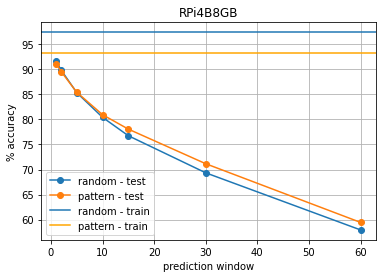

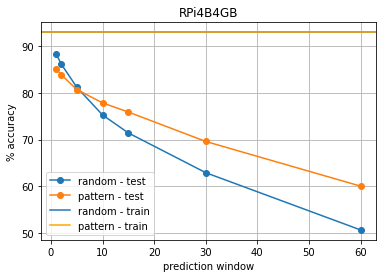

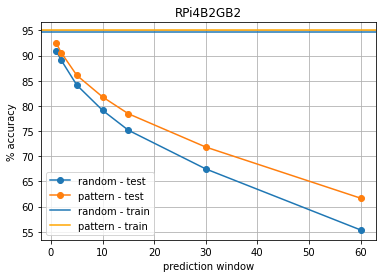

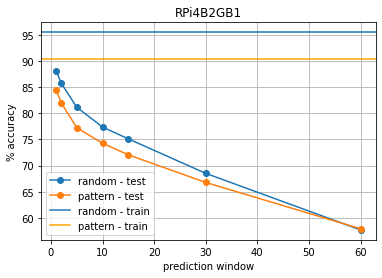

In [11]:
import matplotlib.pyplot as plt


for device in test_accuracy:
    for model in test_accuracy[device]:
        if 'random' in model and '2' not in model:
            test_random_1 = test_accuracy[device][model]
            test_states_random_1 = test_accuracy[device][model]
            train_states_random_1 = train_accuracy_states[device][model]
        elif 'pattern' in model and '2' not in model:
            test_pattern_1 = test_accuracy[device][model]
            test_states_pattern_1 = test_accuracy[device][model]
            train_states_pattern_1 = train_accuracy_states[device][model]
        elif 'random' in model and '2' in model:
            test_random_2 = test_accuracy[device][model]
            test_states_random_2 = test_accuracy[device][model]
            train_states_random_2 = train_accuracy_states[device][model]
        elif 'pattern' in model and '2' in model:
            test_pattern_2 = test_accuracy[device][model]
            test_states_pattern_2 = test_accuracy[device][model]
            train_states_pattern_2 = train_accuracy_states[device][model]

    plt.plot(prediction_windows,[(r1 + r2) / 2 for r1, r2 in zip(test_random_1, test_random_2)], marker='o',label = 'random - test')
    plt.plot(prediction_windows,[(p1 + p2) / 2 for p1, p2 in zip(test_pattern_1, test_pattern_2)], marker='o',label = 'pattern - test')
    plt.axhline(mean(train_states_random_1)*100,label='random - train')
    plt.axhline(mean(train_states_pattern_1)*100,color='orange',label='pattern - train')
    plt.title(device)
    plt.legend(loc='best')
    plt.ylabel('% accuracy')
    plt.xlabel('prediction window')
    plt.grid()
    plt.show()